In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

In [2]:
vws = jnp.linspace(1000., 30000., 1000000)

In [3]:
from two_layers_model import TwoLayersWithLine
tlm = TwoLayersWithLine()

We have a model of a stellar atmosphere. It consists of a black body radiator in the background and a layer of gas on top. This layer of gas exhibits some continuum absorption and one absorption feature due to additional opacity concentrated around 5500 $\AA$ (~a spectral line). The model includes an exact version where the flux and intensity are precisely calculated, as well as a version that approximates the angular dependence using the linear limb darkening law.

See two sections below to understand the overall picture.

## Two Layers with Single Line: Intensity for a chosen angle, Exact integration

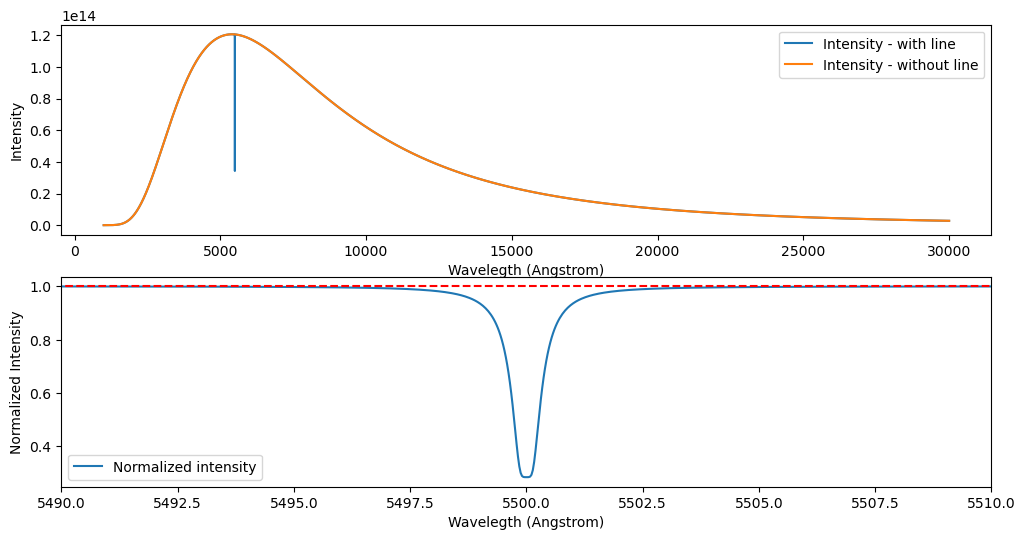

In [4]:
mu = jnp.array([0.5])
p = jnp.array([5777., 4000., 0.1, 3e-10]) # [T_bg, T_fg, gamma, rho0] # K, K, Angstrom, g cm-3
intensity = tlm.intensity(jnp.log10(vws), mu, p)

# ---

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(12, 6))
ax1.plot(vws, intensity[:,0], label='Intensity - with line')
ax1.plot(vws, intensity[:,1], label='Intensity - without line')
ax1.set_xlabel('Wavelegth (Angstrom)')
ax1.set_ylabel('Intensity')
ax1.legend()

# Zoom into normalized intensity
ax2.plot(vws, intensity[:,0]/intensity[:,1], label='Normalized intensity')
ax2.hlines(1, 5000, 6000, colors='r', linestyles='dashed')
ax2.set_xlabel('Wavelegth (Angstrom)')
ax2.set_ylabel('Normalized Intensity')
ax2.legend()
ax2.set_xlim(5490, 5510)
plt.show()

## Two Layers with Single Line: Intensity for a set of angles + limb darkening in line center and in the continuum



In [5]:
mus = jnp.array([1.0, 0.3, 0.1, 0.03, 0.01])
p = jnp.array([5777., 4000., 0.1, 3e-11]) # [T_bg, T_fg, gamma, rho0] # K, K, Angstrom, g cm-3
limb_darkening_coeff = 0.6
intensities = jnp.array([tlm.intensity(jnp.log10(vws), mu, p) for mu in mus])
intensities_lld = jnp.array([tlm.intensity_linear_limb_darkening(jnp.log10(vws), mu, p, limb_darkening_coeff) for mu in mus])

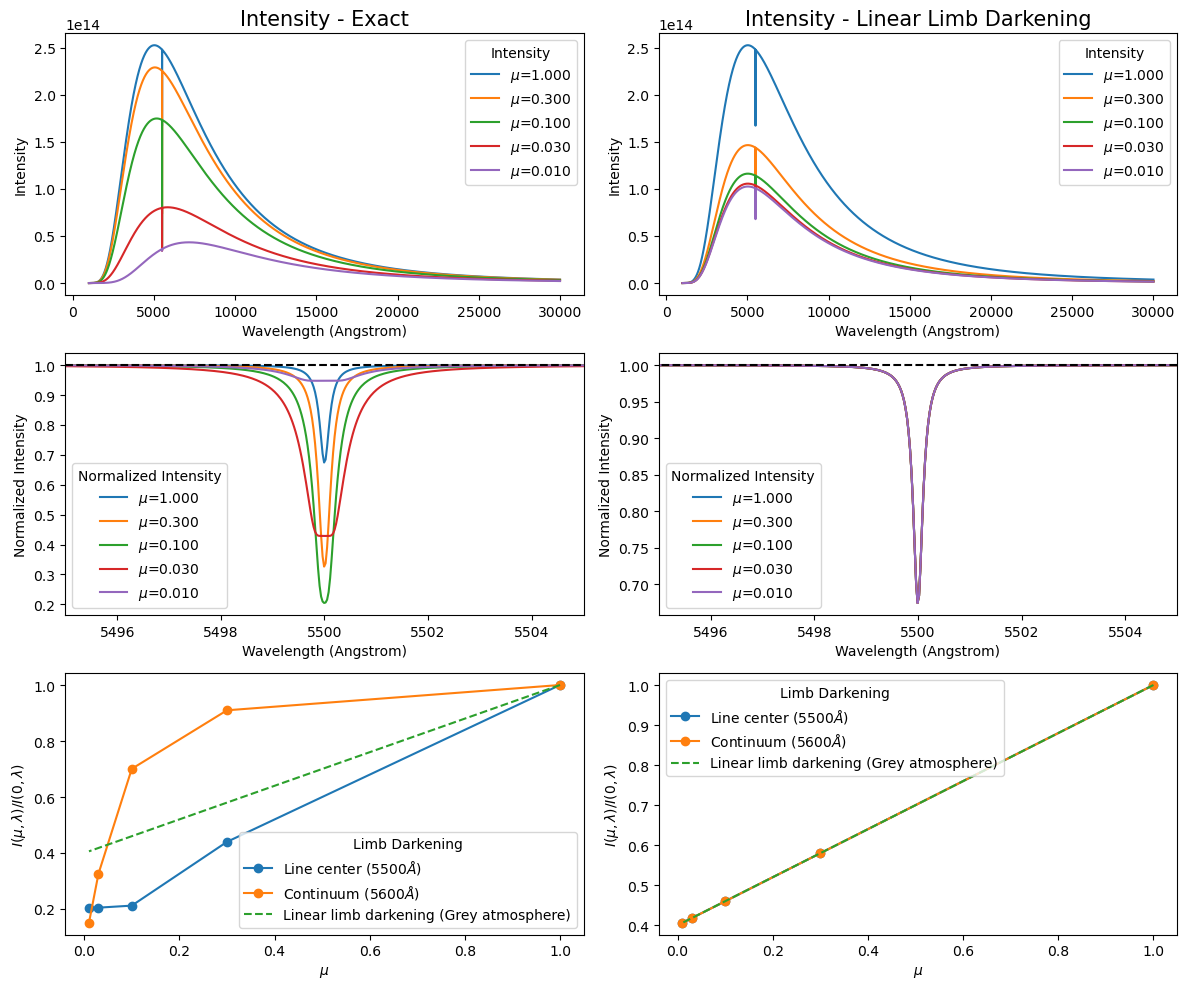

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Plotting original intensities in the first column
for i, mu in enumerate(mus):
    ax1[0].plot(vws, intensities[i, :, 0], label=f'$\mu$={mu:.3f}')
    ax2[0].plot(vws, intensities[i, :, 0] / intensities[i][:, 1], label=f'$\mu$={mu:.3f}')

ax1[0].set_xlabel('Wavelength (Angstrom)')
ax1[0].set_ylabel('Intensity')
ax1[0].legend(title="Intensity")

ax2[0].hlines(1, 5000, 6000, colors='k', linestyles='dashed')
ax2[0].set_xlabel('Wavelength (Angstrom)')
ax2[0].set_ylabel('Normalized Intensity')
ax2[0].legend(title='Normalized Intensity')
ax2[0].set_xlim(5495, 5505)

# Plotting limb-darkened intensities in the second column
for i, mu in enumerate(mus):
    ax1[1].plot(vws, intensities_lld[i, :, 0], label=f'$\mu$={mu:.3f}')
    ax2[1].plot(vws, intensities_lld[i, :, 0] / intensities_lld[i][:, 1], label=f'$\mu$={mu:.3f}')

ax1[1].set_xlabel('Wavelength (Angstrom)')
ax1[1].set_ylabel('Intensity')
ax1[1].legend(title="Intensity")

ax2[1].hlines(1, 5000, 6000, colors='k', linestyles='dashed')
ax2[1].set_xlabel('Wavelength (Angstrom)')
ax2[1].set_ylabel('Normalized Intensity')
ax2[1].legend(title='Normalized Intensity')
ax2[1].set_xlim(5495, 5505)

# Plot intensity for different mu for a chosen wavelengths [5500, 5600] in the third row
idx_w0 = jnp.argmin(jnp.abs(vws - 5500))
idx_w1 = jnp.argmin(jnp.abs(vws - 5600))

ax3[0].plot(mus, intensities[:, idx_w0, 0] / intensities[0, idx_w0, 0], "o-", label="Line center (5500$\AA$)")
ax3[0].plot(mus, intensities[:, idx_w1, 0] / intensities[0, idx_w1, 0], "o-", label="Continuum (5600$\AA$)")
ax3[0].plot(mus, 1 - 0.6 * (1 - mus), "--", label="Linear limb darkening (Grey atmosphere)")
ax3[0].set_xlabel("$\mu$")
ax3[0].set_ylabel("$I(\mu, \lambda) / I(0, \lambda)$")
ax3[0].legend(title="Limb Darkening")

ax3[1].plot(mus, intensities_lld[:, idx_w0, 0] / intensities_lld[0, idx_w0, 0], "o-", label="Line center (5500$\AA$)")
ax3[1].plot(mus, intensities_lld[:, idx_w1, 0] / intensities_lld[0, idx_w1, 0], "o-", label="Continuum (5600$\AA$)")
ax3[1].plot(mus, 1 - 0.6 * (1 - mus), "--", label="Linear limb darkening (Grey atmosphere)")
ax3[1].set_xlabel("$\mu$")
ax3[1].set_ylabel("$I(\mu, \lambda) / I(0, \lambda)$")
ax3[1].legend(title="Limb Darkening")

ax1[0].set_title("Intensity - Exact",fontsize=15)
ax1[1].set_title("Intensity - Linear Limb Darkening", fontsize=15)

plt.tight_layout()
plt.show()

## Rotating star in various approximations (exact / linear limb darkening)

In [7]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
import astropy.units as u
from spice.spectrum import simulate_spectrum

min_number_of_triangles = 1000
chunk_size = 1
vws = jnp.geomspace(5450., 5550., 10000)

p =  jnp.array([5777., 4000., 0.1, 3e-11]) # [T_bg, T_fg, gamma, rho0] # K, K, Angstrom, g cm-3

m = IcosphereModel.construct(min_number_of_triangles, u.solRad.to(u.cm), 1., 1., p) # took ~4min23sec for 1500 (macbook pro 2019), 3.8sec for 1000

### Compare flux to spectrum integrated from star without rotation

They should be the same - let's confirm it by direct evaluation.

In [8]:
flux = tlm.flux(jnp.log10(vws), p)
spec_no_rot = simulate_spectrum(tlm.intensity, m, jnp.log10(vws), chunk_size=chunk_size)

flux_lld = tlm.flux_linear_limb_darkening(jnp.log10(vws), p)
spec_no_rot_lld = simulate_spectrum(tlm.intensity_linear_limb_darkening, m, jnp.log10(vws), chunk_size=chunk_size)

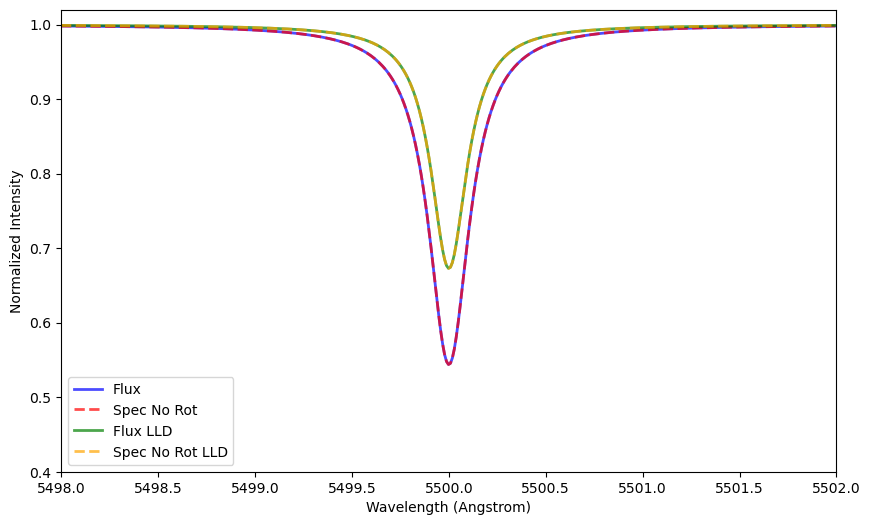

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(vws, flux[:, 0] / flux[:, 1], label='Flux', color='blue', linestyle='-', linewidth=2, alpha=0.7)
ax.plot(vws, spec_no_rot[:, 0] / spec_no_rot[:, 1], label='Spec No Rot', color='red', linestyle='--', linewidth=2, alpha=0.7)

ax.plot(vws, flux_lld[:, 0] / flux_lld[:, 1], label='Flux LLD', color='green', linestyle='-', linewidth=2, alpha=0.7)
ax.plot(vws, spec_no_rot_lld[:, 0] / spec_no_rot_lld[:, 1], label='Spec No Rot LLD', color='orange', linestyle='--', linewidth=2, alpha=0.7)

ax.set_xlim(5498, 5502)
ax.set_ylim(0.40, 1.02)
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Normalized Intensity')
ax.legend()


### Rotation with exact / linear limb darkening

Here we expect that the convolution with broadening kernel derived analytically will be exact for linear limb darkening emulator while not appropriate for exact model. Let's confirm this with emulation. 

Note: We keep number of triangles to be small to show the effects of imperfect numerical integration.

In [10]:
spectra_rot = [] # rotationally broadened specta with exact intensities
vsinis = [0, 3, 10, 30, 100, 300]
for vsini in vsinis:

    mt = add_rotation(m, vsini, jnp.array([0., 0., 1.]))
    mt = evaluate_rotation(mt, 0.0)
    %time spec_vsini = simulate_spectrum(tlm.intensity, mt, jnp.log10(vws), chunk_size=chunk_size).block_until_ready()

    spectra_rot.append(spec_vsini)

spectra_rot_lld = [] # rotationally broadened specta with linear limb darkening
for vsini in vsinis:

    mt = add_rotation(m, vsini, jnp.array([0., 0., 1.]))
    mt = evaluate_rotation(mt, 0.0)
    %time spec_vsini = simulate_spectrum(tlm.intensity_linear_limb_darkening, mt, jnp.log10(vws), chunk_size=chunk_size).block_until_ready()

    spectra_rot_lld.append(spec_vsini)

flux_exact = tlm.flux(jnp.log10(vws), p)
flux_exact_lld = tlm.flux_linear_limb_darkening(jnp.log10(vws), p)
    

CPU times: user 1.61 s, sys: 98.9 ms, total: 1.7 s
Wall time: 620 ms
CPU times: user 1.42 s, sys: 93.5 ms, total: 1.51 s
Wall time: 426 ms
CPU times: user 1.31 s, sys: 81.5 ms, total: 1.4 s
Wall time: 569 ms
CPU times: user 1.39 s, sys: 90.5 ms, total: 1.48 s
Wall time: 459 ms
CPU times: user 1.33 s, sys: 83.6 ms, total: 1.42 s
Wall time: 485 ms
CPU times: user 1.36 s, sys: 88.2 ms, total: 1.45 s
Wall time: 479 ms
CPU times: user 1.65 s, sys: 100 ms, total: 1.75 s
Wall time: 674 ms
CPU times: user 1.5 s, sys: 105 ms, total: 1.6 s
Wall time: 479 ms
CPU times: user 1.5 s, sys: 101 ms, total: 1.6 s
Wall time: 478 ms
CPU times: user 1.45 s, sys: 97.1 ms, total: 1.55 s
Wall time: 553 ms
CPU times: user 1.45 s, sys: 95.8 ms, total: 1.54 s
Wall time: 533 ms
CPU times: user 1.48 s, sys: 100 ms, total: 1.58 s
Wall time: 504 ms


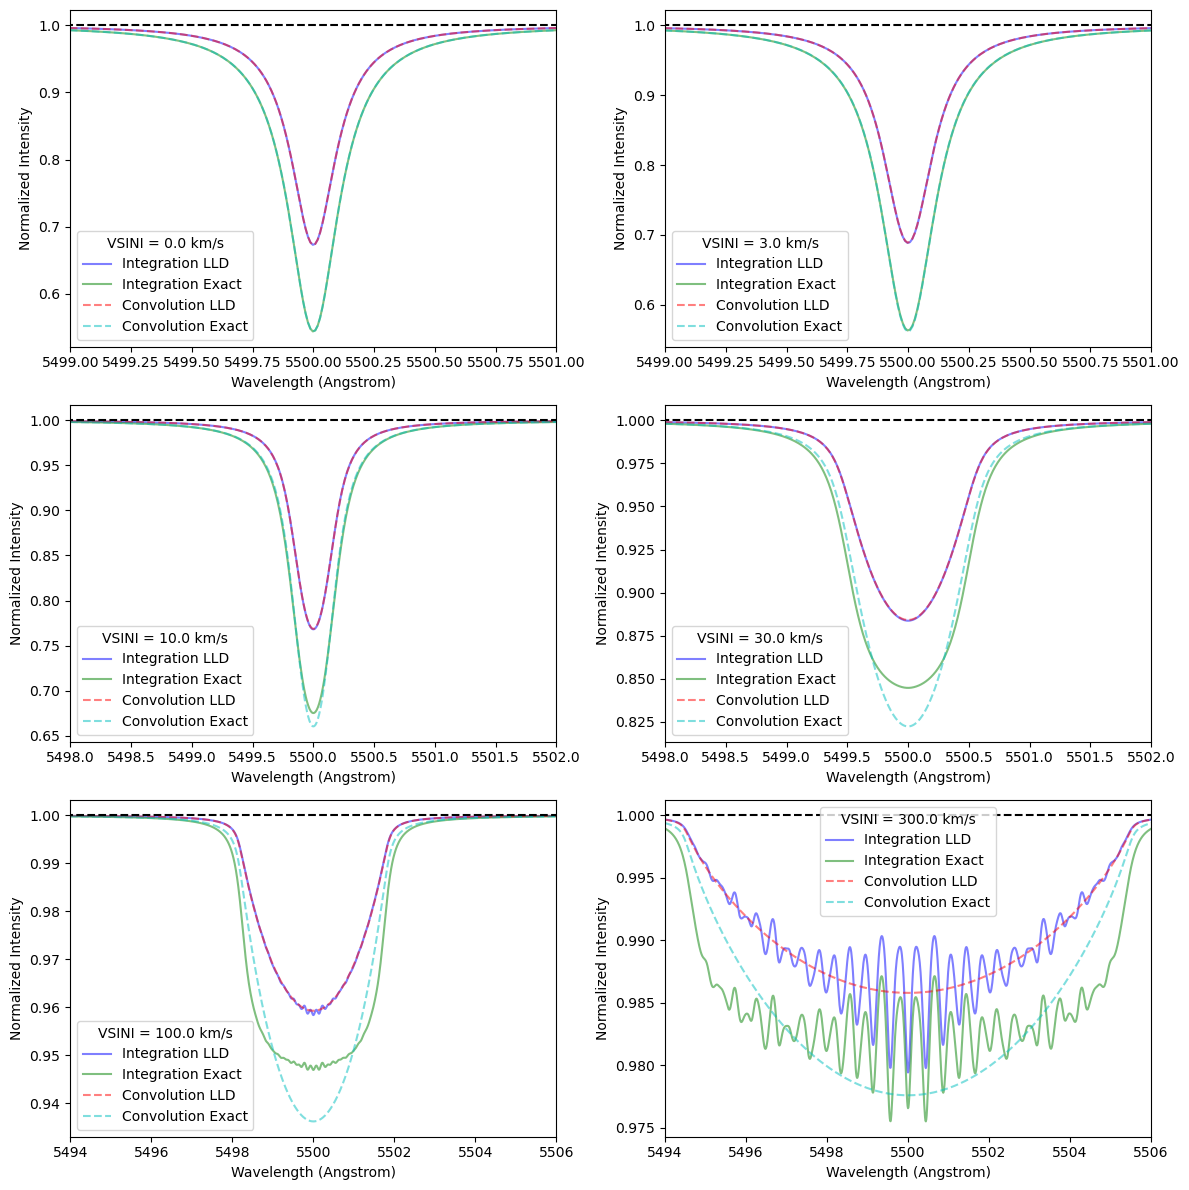

In [11]:
import matplotlib.pyplot as plt
from utils import add_vsini_broadening

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))  # Create 6 subplots

# Define line styles
line_styles = ['-', '--']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
alpha = 0.5
limits = [1,1,2,2,6,6]

normalized_flux_exact = flux_exact[:, 0] / flux_exact[:, 1]
normalized_flux_exact_lld = flux_exact_lld[:, 0] / flux_exact_lld[:, 1]

for i, vsini in enumerate(vsinis):
    ax = axes[i // 2, i % 2]  # Get the appropriate subplot
    color = colors[i % len(colors)]

    # Plot linear limb darkening
    sp_lld = spectra_rot_lld[i]
    ax.plot(vws, sp_lld[:, 0] / sp_lld[:, 1], label=f'Integration LLD', color=colors[0], linestyle=line_styles[0], alpha=alpha)
    
    # Plot exact model
    sp_exact = spectra_rot[i]
    ax.plot(vws, sp_exact[:, 0] / sp_exact[:, 1], label=f'Integration Exact', color=colors[1], linestyle=line_styles[0], alpha=alpha)
    
    # Plot spectra convolved with analytical rotational kernel with linear limb darkening:
    if vsini > 0.0:
        flux_conv_lld_vsini = add_vsini_broadening(np.log10(vws), normalized_flux_exact_lld, vsini=vsini, limb_darkening_coeff=0.6)
    else:
        flux_conv_lld_vsini = normalized_flux_exact_lld
    ax.plot(vws, flux_conv_lld_vsini, label=f'Convolution LLD', color=colors[2], linestyle=line_styles[1], alpha=alpha)

    # Plot flux convolved with analytical rotational kernel with linear limb darkening:
    if vsini > 0.0:
        flux_conv_lld_vsini = add_vsini_broadening(np.log10(vws), normalized_flux_exact, vsini=vsini, limb_darkening_coeff=0.6)
    else:
        flux_conv_lld_vsini = normalized_flux_exact
    ax.plot(vws, flux_conv_lld_vsini, label=f'Convolution Exact', color=colors[3], linestyle=line_styles[1], alpha=alpha)

    ax.hlines(1, 5000, 6000, colors='k', linestyles='dashed')
    ax.set_xlabel('Wavelength (Angstrom)')
    ax.set_ylabel('Normalized Intensity')
    ax.legend(title=f"VSINI = {vsini:.1f} km/s")
    ax.set_xlim(5500-limits[i], 5500+limits[i])

plt.tight_layout()
